## Train an RL agent interacting with a stable grid
In this notebook it will be shown how to control one source with an reinforcement learning (RL) agent learning a control task while connected to a stable grid provided by a classic controller. The topics covered are:

 - ### Merging classic controllers and RL agents,
 - ### Reward and featurize functions with named policies,
 - ### MultiController,
 - ### Training an RL agent in a classically controlled grid.

## Merging classic controllers and RL agents

In this notebook an RL agent is trained to draw current from a stable grid.
The 3-phase electric power grid is formed by a classic controller in open-loop (`Swing`) mode. 
For more details about how the classic control works, see `Classical_Controllers_Introduction.ipynb`.

The use case is shown in the figure below.
This environment consists of a 3-phase electrical power grid with 2 sources connected via a cable (for improved clarity, only one phase is shown in the following figure).

![](figures/RL_classic_swing.png "")

The first source is controlled by the RL agent `my_ddpg` which should learn to draw power from the grid, therefore act like an active load.
The second source is controlled by a classic controller in open-loop mode. 
The swing mode is used to create a stable 3-phase grid to supply the load.

In [1]:
using ElectricGrid

In [2]:
parameters = 
Dict{Any, Any}(
    "source" => Any[
                    Dict{Any, Any}(
                        "pwr" => 200e3, 
                        "control_type" => "RL", 
                        "mode" => "my_ddpg", 
                        "fltr" => "L"),
                    Dict{Any, Any}(
                        "pwr" => 200e3, 
                        "fltr" => "LC", 
                        "control_type" => 
                        "classic", "mode" => 1),
                    ],
    "grid" => Dict{Any, Any}(
        "phase" => 3, 
        "ramp_end" => 0.04,)
)

Dict{Any, Any} with 2 entries:
  "source" => Any[Dict{Any, Any}("control_type"=>"RL", "mode"=>"my_ddpg", "fltr…
  "grid"   => Dict{Any, Any}("phase"=>3, "ramp_end"=>0.04)

Like already introduced in `RL_Single_Agent.ipynb`, an appropriate `reference(t)` function has to be defined to represent the control objectives.
In this example, we will use the time `t` handed over to the function to generate time-varying reference signals.
In more detail a three-phase sinusoidal reference signal shifted by 120° and an amplitude of 10 A is created.
This should teach the agent to draw time-varying current from the grid. 
The phase is thereby chosen similar to the definition in the `Swing` mode:

$i_\mathrm{L,ref} =  - 10 \,\text{cos}\left(2 \pi \,50 \, t - \frac{2}{3} \pi (n-1) \right)$, with $n \in [0,1,2]$.

Here, $n$ represents the index referring to the 3 phases of the grid.

For more enhanced reference functions, the reference current could be chosen in regard to power (active and reactive) reference values.
Feel free to implement, change and contribute! 

In [3]:
function reference(t)
    θ = 2*pi*50*t
    θph = [θ; θ - 120π/180; θ + 120π/180]
    return -10 * cos.(θph) 
end

reference (generic function with 1 method)

## Reward and featurize functions with named policies

Afterwards the `featurize()` function adds the signal generated by the `reference` function to the state for the agent `my_ddpg`:

In [4]:
featurize_ddpg = function(state, env, name)
    if name == "my_ddpg"
        norm_ref = env.nc.parameters["source"][1]["i_limit"]
        state = vcat(state, reference(env.t)/norm_ref)
    end
end

#9 (generic function with 1 method)

Then, the `reward()` function is defined. Here, again it is based on the root-mean-square error (RMSE) teaching the agent `my_ddpg` to match the reference signal to the measured signal. 

If the measured state is greater than `1` a punishment is returned which is chosen to be `r = -1`.
It not and if the measured value differs from the reference, the average error is subtracted from the maximal reward: `r = 1 - RMSE`:

$r = 1 - \frac{1}{3} \sum_{{p \in \{\mathrm{a,b,c}\}}} \sqrt{\frac{|i_\mathrm{L,ref,p} - i_\mathrm{L1,p}|}{2}}$

This function is only used if the name of the policy is `my_ddpg` which was chosen in the parameter dict. 
In any other case, 1 is returned.
This could be used to define 2 different reward functions for 2 different agents via name (e.g., `my_ddpg` and `my_sac`) to learn for example a current control with the `my_ddpg` agent but a voltage control task with the `my_sac` agent.

Here, in any case but `name == my_ddpg` - so in case of the `classic` controller `r = 1` is returned.

In [5]:
function reward_function(env, name = nothing)
    if name == "my_ddpg"
        state_to_control_1 = env.state[findfirst(x -> x == "source1_i_L1_a", env.state_ids)]
        state_to_control_2 = env.state[findfirst(x -> x == "source1_i_L1_b", env.state_ids)]
        state_to_control_3 = env.state[findfirst(x -> x == "source1_i_L1_c", env.state_ids)]

        state_to_control = [state_to_control_1, state_to_control_2, state_to_control_3]

        if any(abs.(state_to_control).>1)
            return -1
        else

            refs = reference(env.t)
            norm_ref = env.nc.parameters["source"][1]["i_limit"]          
            r = 1-1/3*(sum((abs.(refs/norm_ref - state_to_control)/2).^0.5))
            return r 
        end
    else
        return 1
    end

end

reward_function (generic function with 2 methods)

Then, the defined parameters, featurize and reward functions are used to create an environment consisting of the electrical power grid. Here, no `CM` matrix defining the connection is used. Since the grid consists only of 2 sources that is the only connection possible. The `ElectricGridEnv` creates this internally based on the length of the parameter dict sources.

In [6]:
env = ElectricGridEnv(
    parameters = parameters, 
    t_end = 0.1, 
    featurize = featurize_ddpg, 
    reward_function = reward_function, 
    action_delay = 0);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



## MultiController

The `MultiController` ensured that the correct states and actions are linked to the corresponding controllers/agents based on the `"control_type"` and `"mode"` defined in the parameter dict.

 - `"control_type" = "classic"`: Predefined classic controllers are used to calculate the actions for that source based on its states.

 - `"control_type" = "RL"`: Based on the defined agent name (here, `my_ddpg`), the corresponding states are forwarded to the defined RL agent which returns the actions belonging to the source.

In the following, we will use the `CreateAgentDDPG()` method to create the DDPG `agent`. This `agent` is linked in the `my_custom_agents` dict to the chosen name `my_ddpg`, which is used in the `SetupAgents` method to configure the control side of the experiment:

In [7]:
agent = CreateAgentDdpg(na = length(env.agent_dict["my_ddpg"]["action_ids"]),
                          ns = length(state(env, "my_ddpg")),
                          use_gpu = false)

my_custom_agents = Dict("my_ddpg" => agent)

controllers = SetupAgents(env, my_custom_agents);

Like shown in the following figure, the `controllers` struct consists of 2 agents now - one per source.

![](figures/Overview_example.png "")

Since we have defined 2 sources in the env, one controlled classically and the other by RL, the `MultiController` hands over the correct indices of the environment to the controllers:


In [8]:
controllers.agents

Dict{Any, Any} with 2 entries:
  "classic" => Dict{Any, Any}("policy"=>typename(NamedPolicy)…
  "my_ddpg" => Dict{Any, Any}("policy"=>typename(Agent)…

This enables each controller, e.g., to find the correct subset of states in the entire environment state set.
In the parameter dict the first source is labeled to be controlled by the RL agent we named `my_ddpg`: 

In [9]:
controllers.agents["my_ddpg"]

Dict{Any, Any} with 3 entries:
  "policy"     => typename(Agent)…
  "action_ids" => ["source1_u_a", "source1_u_b", "source1_u_c"]
  "state_ids"  => ["source1_i_L1_a", "source1_v_C_cables_a", "source1_i_L1_b", …

Like introduced, it has knowledge about the state and action indices of the first source.

The second source is controlled via the classic controller: 

In [10]:
controllers.agents["classic"]

Dict{Any, Any} with 3 entries:
  "policy"     => typename(NamedPolicy)…
  "action_ids" => ["source2_u_a", "source2_u_b", "source2_u_c"]
  "state_ids"  => ["source2_i_L1_a", "source2_v_C_filt_a", "source2_v_C_cables_…

## Training an RL agent in a classically controlled grid

Then the `Learn()` function is used to train 20 episodes. 
Here, only the RL agent is trained. 
The classic controller is executed to control the second source without parameter adaptions.

In [11]:
Learn(controllers, env, num_episodes = 1000);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:27


                 ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀        
                 ┌────────────────────────────────────────┐        
            1001 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡏⠉⠉⠉⢉⣩⠭⠭⠭⠭│ classic
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡇⠀⠀⢀⡞⠀⠀⠀⠀⠀│ my_ddpg
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡇⠀⣠⠇⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡇⣰⠋⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡷⠃⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
   Score         │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡞⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣤⢀⣀⣸⠀⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⢸⠁⠀⡴⠿⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⢸⢤⡴⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣼⠀⠀⠀⠀

In the output the two different rewards for `classic` and `my_ddpg` can be identified.
Shown is the accumulated reward per episode. Since the `classic` gets `r = 1` per step, this reward correlates with the length of the episode while the reward for the `my_ddpg` agent is depending on the above described reward function.
After the training, the `Simulate()` function is used to run a test episode without action noise and the all states and actions are plotted:

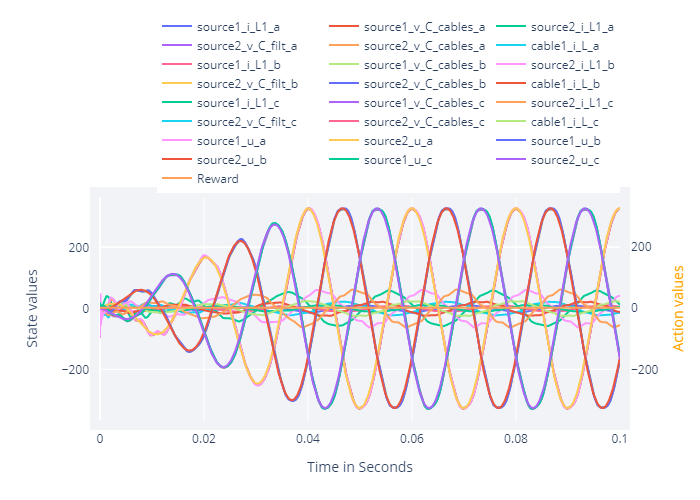

In [12]:
hook = DataHook(collect_state_ids = env.state_ids,
                collect_action_ids = env.action_ids)

hook = Simulate(controllers, env, hook=hook)


RenderHookResults(hook = hook,
                    states_to_plot  = env.state_ids,
                    actions_to_plot = env.action_ids,
                    plot_reward=true)
